# Visualization

* find a way so that you select one pixel in the original image and see which pixels in the reconstructed image are affected by it -> this is like taking one row/column of the attention matrix
* you can take an off the shelf segmentation model and with that create a map of the original image (like color blocks thanks to majority voting) -> then see how does the model perform on that


# Improvements -> IDEA
* make it so that you're not using cutout but extracting them from 360 -> search for preexisting function
* you can compute the n_patches x n_patches distance matrix between the positional embeddings of both images
    - this means that for the aerial image you'll have a 64 x 64 matrix and for the ground image a 256 x 256
    - then you can binarize this matrix by setting all values to 0 except for some elements which will be 1 according to a criterion
        - top k closest elements
        - distance between the embeddings is less than a threshold like 8 pixels

* let's consider the G2A attention matrix to be a 64 x 256 matrix
    - you should normalize it
    - you should compute the cosine similarity of this attention matrix by computing the matmul with its transpose
    - the cosine similarity matrix will be a 64 x 64 matrix

* then, the loss on the attention map is given by the cosine similarity multiplied by the binarized distance matrix
    - this loss should be added to the reconstruction loss

* contrastive loss 

In [2]:
from PIL import Image
import numpy as np
import torch
import torch.nn as nn
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import cv2
import sys
from sklearn.neighbors import NearestNeighbors
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
from matplotlib.patches import ConnectionPatch
import numpy as np
from torch.utils.data import Dataset, DataLoader
import os
import random

import torch
import torch.nn as nn
import torch.optim as optim
import os
import argparse
from torch.utils.data import DataLoader
from torchvision import transforms
from PIL import ImageFile
from tqdm import tqdm
import numpy as np
from dataset import PairedImagesDataset, sample_cvusa_images
from model import CroDINO, Dinov2Matcher, CosineSimilarityLoss, get_combined_embedding_visualization_all

In [3]:
# Sample paired images
dataset_path = '/home/lrusso/cvusa/CVPR_subset'
train_filenames, val_filenames = sample_cvusa_images(dataset_path, sample_percentage=0.2, split_ratio=0.8, groundtype='panos')

# Settings
image_size = 224 * 2
aerial_scaling = 2
provide_paths = False
BATCH_SIZE = 1

transform_ground = transforms.Compose([
    transforms.Resize((image_size, image_size)),
    transforms.CenterCrop((image_size, image_size)),
    transforms.ToTensor()
])

transform_aerial = transforms.Compose([
    transforms.Resize((image_size*aerial_scaling, image_size*aerial_scaling)),
    transforms.CenterCrop((image_size, image_size)),
    transforms.ToTensor()
])

# Instantiate the dataset and dataloader
paired_dataset = PairedImagesDataset(train_filenames, transform_aerial=transform_aerial, transform_ground=transform_ground, cutout_from_pano=True)
data_loader = DataLoader(paired_dataset, batch_size=BATCH_SIZE, shuffle=True)

# Define the Device
device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using device: {device}")

# Load the Model
repo_name="facebookresearch/dinov2"
model_name="dinov2_vitb14"
model = CroDINO(repo_name, model_name, pretrained=True).to(device)

# Load a single pair of images
ground_image, aerial_image, fov, yaw, pitch = next(iter(data_loader))
ground_image = ground_image.to(device)
aerial_image = aerial_image.to(device)

print("fov", fov)
print("yaw", yaw)
print("pitch", pitch)

panos
Using device: cuda


Using cache found in /home/lrusso/.cache/torch/hub/facebookresearch_dinov2_main


fov [tensor([90]), tensor([180])]
yaw tensor([322])
pitch tensor([90])


In [ ]:
# Compute the output of the model
ground_tokens, aerial_tokens, attention = model(ground_image, aerial_image, debug=True)

print("ground tokens shape:", ground_tokens.shape)
print("aerial tokens shape:", aerial_tokens.shape)

# Visualize the final single-head attention layer
attention = attention.mean(dim=1)  # average across heads only
print("attention shape: ", attention.shape)

# Calculate the number of patches for ground and aerial images
num_patches_ground = (ground_image.shape[-1] // model.patch_size) * (ground_image.shape[-2] // model.patch_size)
num_patches_aerial = (aerial_image.shape[-1] // model.patch_size) * (aerial_image.shape[-2] // model.patch_size)

# Remove the first row and column
attention = attention[:, 1:, 1:]

# Remove the row and column corresponding to 1+num_patches_ground
attention = torch.cat((attention[:, :num_patches_ground-1, :], attention[:, num_patches_ground:, :]), dim=1)
attention = torch.cat((attention[:, :, :num_patches_ground-1], attention[:, :, num_patches_ground:]), dim=2)

# Retrieve Cross Attention
cross_attention_A2G = attention[:, :num_patches_ground, num_patches_ground:]
cross_attention_G2A = attention[:, num_patches_ground:, :num_patches_ground]
print("num_patches_ground: ", num_patches_ground)
print("num_patches_aerial: ", num_patches_aerial)
print("cross_attention_G2A shape: ", cross_attention_G2A.shape)
print("cross_attention_A2G shape: ", cross_attention_A2G.shape)

# Reconstruct the images from the tokens
reconstructed_aerial = torch.matmul(cross_attention_G2A, ground_tokens)
reconstructed_ground = torch.matmul(cross_attention_A2G, aerial_tokens)
# reconstructed_aerial = torch.matmul(cross_attention_A2G, ground_tokens)
# reconstructed_ground = torch.matmul(cross_attention_G2A, aerial_tokens)    # you should try training in different combinations
print("reconstructed_ground shape: ", reconstructed_ground.shape)
print("reconstructed_aerial shape: ", reconstructed_aerial.shape)

# Normalize the reconstructed images
reconstructed_ground = model.norm(reconstructed_ground)
reconstructed_aerial = model.norm(reconstructed_aerial)

# Compute Loss
# criterion = nn.MSELoss()
criterion = CosineSimilarityLoss()
loss_ground = criterion(reconstructed_ground, ground_tokens)
loss_aerial = criterion(reconstructed_aerial, aerial_tokens)
print("Ground Loss: ", loss_ground.item())
print("Aerial Loss: ", loss_aerial.item())
print("Total loss: ", loss_ground.item() + loss_aerial.item())

# Convert tensors to numpy
cross_attention_G2A = cross_attention_G2A.cpu().detach().numpy()
cross_attention_A2G = cross_attention_A2G.cpu().detach().numpy()

# Convert images to numpy for visualization
ground_image_np = ground_image.squeeze().permute(1, 2, 0).detach().cpu().numpy()
aerial_image_np = aerial_image.squeeze().permute(1, 2, 0).detach().cpu().numpy()

print("Ground image pixel values (min, max):", ground_image_np.min(), ground_image_np.max())
print("Aerial image pixel values (min, max):", aerial_image_np.min(), aerial_image_np.max())

# Plot the ground image and aerial image
fig, ax = plt.subplots(1, 2, figsize=(12, 6))
ax[0].imshow(ground_image_np)
ax[0].set_title("Ground Image")
ax[0].axis('off')
ax[1].imshow(aerial_image_np)
ax[1].set_title("Aerial Image")
ax[1].axis('off')
plt.show()

# Determine common vmin and vmax for color scales
vmin = min(cross_attention_G2A.min(), cross_attention_A2G.min())
vmax = max(cross_attention_G2A.max(), cross_attention_A2G.max())

# Plot the cross-attention maps with common color scale
fig, ax = plt.subplots(1, 2, figsize=(12, 6))
img0 = ax[0].imshow(cross_attention_G2A.squeeze(), cmap='viridis', vmin=vmin, vmax=vmax)
ax[0].set_title("Cross Attention: Ground to Aerial")
ax[0].set_xlabel("Aerial Tokens")
ax[0].set_ylabel("Ground Tokens")
fig.colorbar(img0, ax=ax[0])
img1 = ax[1].imshow(cross_attention_A2G.squeeze(), cmap='viridis', vmin=vmin, vmax=vmax)
ax[1].set_title("Cross Attention: Aerial to Ground")
ax[1].set_xlabel("Ground Tokens")
ax[1].set_ylabel("Aerial Tokens")
fig.colorbar(img1, ax=ax[1])
plt.show()

# Visualize the whole attention map with common color scale
plt.imshow(attention.squeeze().detach().cpu().numpy(), cmap='viridis', vmin=vmin, vmax=vmax)
plt.title("Attention Map")
plt.xlabel("Tokens")
plt.ylabel("Tokens")
plt.colorbar()
plt.show()

x1_img shape:  torch.Size([1, 3, 448, 448])
x2_img shape:  torch.Size([1, 3, 448, 448])
x1_dino shape:  torch.Size([1, 1024, 768])
x2_dino shape:  torch.Size([1, 1024, 768])
x1_cls shape:  torch.Size([1, 1, 768])
x2_cls shape:  torch.Size([1, 1, 768])
ground tokens shape: torch.Size([1, 1024, 768])
aerial tokens shape: torch.Size([1, 1024, 768])


TypeError: 'int' object is not subscriptable

In [6]:
ground_image_vis = ground_image.squeeze(0).cpu().numpy().transpose(1, 2, 0) * 255
aerial_image_vis = aerial_image.squeeze(0).cpu().numpy().transpose(1, 2, 0) * 255
ground_image_vis = ground_image_vis.astype(np.uint8)
aerial_image_vis = aerial_image_vis.astype(np.uint8)

# Init Dinov2Matcher
dm = Dinov2Matcher()

# Extract features
image_tensor1, grid_size1, resize_scale1 = dm.prepare_image(ground_image_vis)
image_tensor2, grid_size2, resize_scale2 = dm.prepare_image(aerial_image_vis)
tokens_1 = ground_tokens.squeeze(0).detach().cpu().numpy()
tokens_2 = aerial_tokens.squeeze(0).detach().cpu().numpy()
grid_size4 = grid_size2
grid_size2_reduced = grid_size2
tokens_3 = reconstructed_ground.squeeze(0).detach().cpu().numpy()
tokens_4 = reconstructed_aerial.squeeze(0).detach().cpu().numpy()

# More info
print("ground_image shape:", ground_image.shape)
print("aerial_image shape:", aerial_image.shape)
print("tokens_1 shape:", tokens_1.shape)
print("tokens_2 shape:", tokens_2.shape)
print("grid_size1:", grid_size1)
print("grid_size2:", grid_size2)
print("grid_size2_reduced:", grid_size2_reduced)
print("resize_scale1:", resize_scale1)
print("resize_scale2:", resize_scale2)

# # Visualization - Baseline
# fig, ((ax1, ax2), (ax3, ax4), (ax5, ax6)) = plt.subplots(3, 2, figsize=(12, 15))
# ax1.imshow(ground_image_vis)
# ax1.set_title('Ground Image')
# ax2.imshow(aerial_image_vis)
# ax2.set_title('Aerial Image')
# vis_combined1, vis_combined2, vis_combined3, vis_combined4 = get_combined_embedding_visualization_all(dm.extract_features(image_tensor1), dm.extract_features(image_tensor2), tokens_1, tokens_2, grid_size1, grid_size2, grid_size1, grid_size2_reduced, debug=True)
# ax3.imshow(vis_combined1)
# ax3.set_title('Combined Features 1 - Reference')
# ax4.imshow(vis_combined2)
# ax4.set_title('Combined Features 2 - Reference')
# ax5.imshow(vis_combined3)
# ax5.set_title('Combined Features 1')
# ax6.imshow(vis_combined4)
# ax6.set_title('Combined Features 2')
# fig.suptitle("Common Baseline for All Images + Reference")
# fig.tight_layout()

# Visualization - Baseline
fig, ((ax1, ax2), (ax3, ax4), (ax5, ax6)) = plt.subplots(3, 2, figsize=(12, 15))
ax1.imshow(ground_image_vis)
ax1.set_title('Ground Image')
ax2.imshow(aerial_image_vis)
ax2.set_title('Aerial Image')
vis_combined1, vis_combined2 = dm.get_combined_embedding_visualization(tokens_1, tokens_2, grid_size1, grid_size2_reduced)
vis_combined3, vis_combined4 = dm.get_combined_embedding_visualization(tokens_3, tokens_4, grid_size1, grid_size4)
ax3.imshow(vis_combined1)
ax3.set_title('Features 1')
ax4.imshow(vis_combined2)
ax4.set_title('Features 2')
ax5.imshow(vis_combined3)
ax5.set_title('Features 1 - Reconstructed')
ax6.imshow(vis_combined4)
ax6.set_title('Features 2 - Reconstructed')
fig.suptitle("Common Baseline for Image Row")
fig.tight_layout()

# # Visualization - Reconstructed Images
# fig, ((ax1, ax2), (ax3, ax4), (ax5, ax6)) = plt.subplots(3, 2, figsize=(12, 15))
# ax1.imshow(ground_image_vis)
# ax1.set_title('Ground Image')
# ax2.imshow(aerial_image_vis)
# ax2.set_title('Aerial Image')
# vis_combined1, vis_combined2, vis_combined3, vis_combined4 = get_combined_embedding_visualization_all(tokens_1, tokens_2, tokens_3, tokens_4, grid_size1, grid_size2, grid_size1, grid_size4, debug=True)
# ax3.imshow(vis_combined1)
# ax3.set_title('Combined Features 1')
# ax4.imshow(vis_combined2)
# ax4.set_title('Combined Features 2')
# ax5.imshow(vis_combined3)
# ax5.set_title('Combined Features 1 - Reconstructed')
# ax6.imshow(vis_combined4)
# ax6.set_title('Combined Features 2 - Reconstructed')
# fig.suptitle("Common Baseline for All Images")
# fig.tight_layout()

Using cache found in /home/lrusso/.cache/torch/hub/facebookresearch_dinov2_main


NameError: name 'reconstructed_ground' is not defined

 ?> Using provider CPUExecutionProvider
 -> Loading the model
 ?> The model is valid!


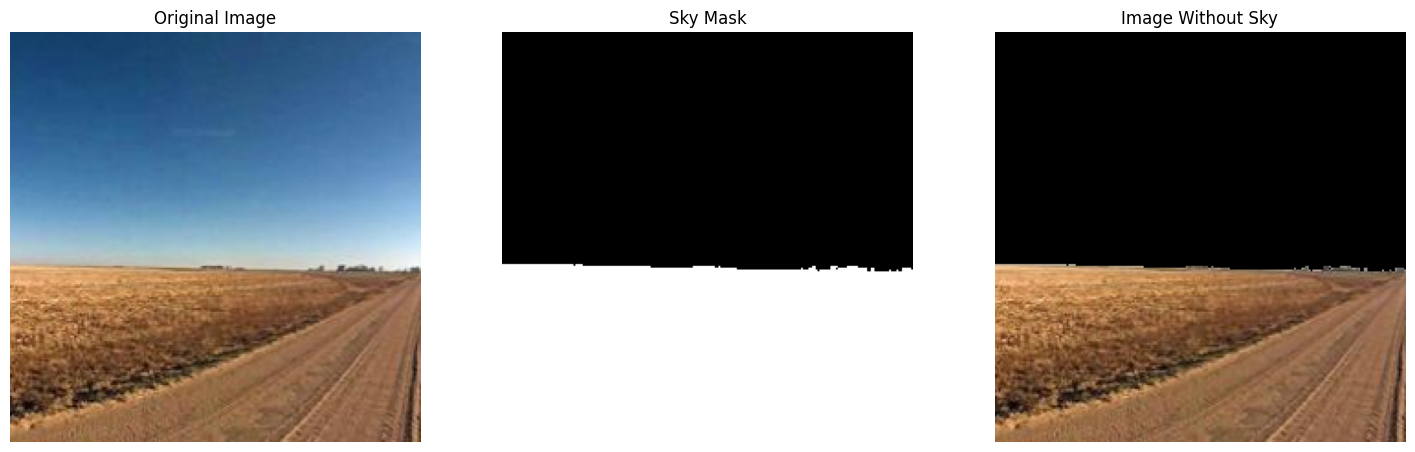

In [ ]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
from skyfilter import SkyFilter

# Initialize the sky filter
sky_filter = SkyFilter()

# Process the image array directly
ground_image_no_sky, sky_mask = sky_filter.run_img_array(ground_image_vis)

# sky_mask = cv2.bitwise_not(sky_mask)

# Visualize the original image, mask, and the sky-removed image
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(18, 6))
ax1.imshow(ground_image_vis)
ax1.set_title("Original Image")
ax1.axis('off')

ax2.imshow(sky_mask, cmap='gray')
ax2.set_title("Sky Mask")
ax2.axis('off')

ax3.imshow(ground_image_no_sky)
ax3.set_title("Image Without Sky")
ax3.axis('off')

plt.show()

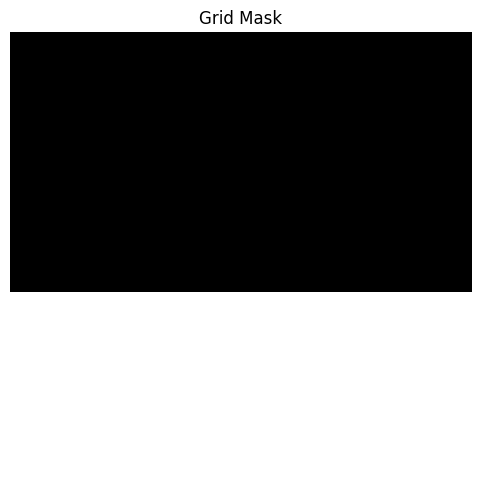

In [ ]:
# Define the grid size
grid_size = 16  # This can be changed according to your ViT's grid size

# Dimensions of the image
height, width = ground_image_no_sky.shape[:2]

# Calculate the size of each grid cell
cell_height = height // grid_size
cell_width = width // grid_size

# Initialize the grid mask
grid_mask = np.zeros((grid_size, grid_size), dtype=np.uint8)

# Loop over each cell in the grid
for i in range(grid_size):
    for j in range(grid_size):
        # Define the region of interest (ROI) for this cell
        start_x = j * cell_width
        start_y = i * cell_height
        end_x = (j + 1) * cell_width if j < grid_size - 1 else width
        end_y = (i + 1) * cell_height if i < grid_size - 1 else height
        
        # Extract the cell from the sky mask
        cell = sky_mask[start_y:end_y, start_x:end_x]
        
        # Apply majority voting: if more than half of the cell is sky, mark it as sky
        if np.mean(cell) > 127:  # Since the mask is binary, 127 is the midpoint
            grid_mask[i, j] = 1  # Mark as ground
        else:
            grid_mask[i, j] = 0  # Mark as ground

# Visualize the grid mask
plt.figure(figsize=(6, 6))
plt.imshow(grid_mask, cmap='gray')
plt.title("Grid Mask")
plt.axis('off')
plt.show()

normalized_features1.shape: (256, 768)
normalized_features2.shape: (256, 768)
grid_size: 16
averaged_vertical_tokens.shape: (16, 768)
averaged_radial_tokens.shape: (64, 768)
Min Distance: 1.0297 	Best Orientation: 0.0°
Min Distance: 1.0286 	Best Orientation: 326.25°
Min Distance: 1.0278 	Best Orientation: 331.875°
Min Distance: 1.0273 	Best Orientation: 343.125°
Min Distance: 1.0271 	Best Orientation: 348.75°
Confidence: 2.1552


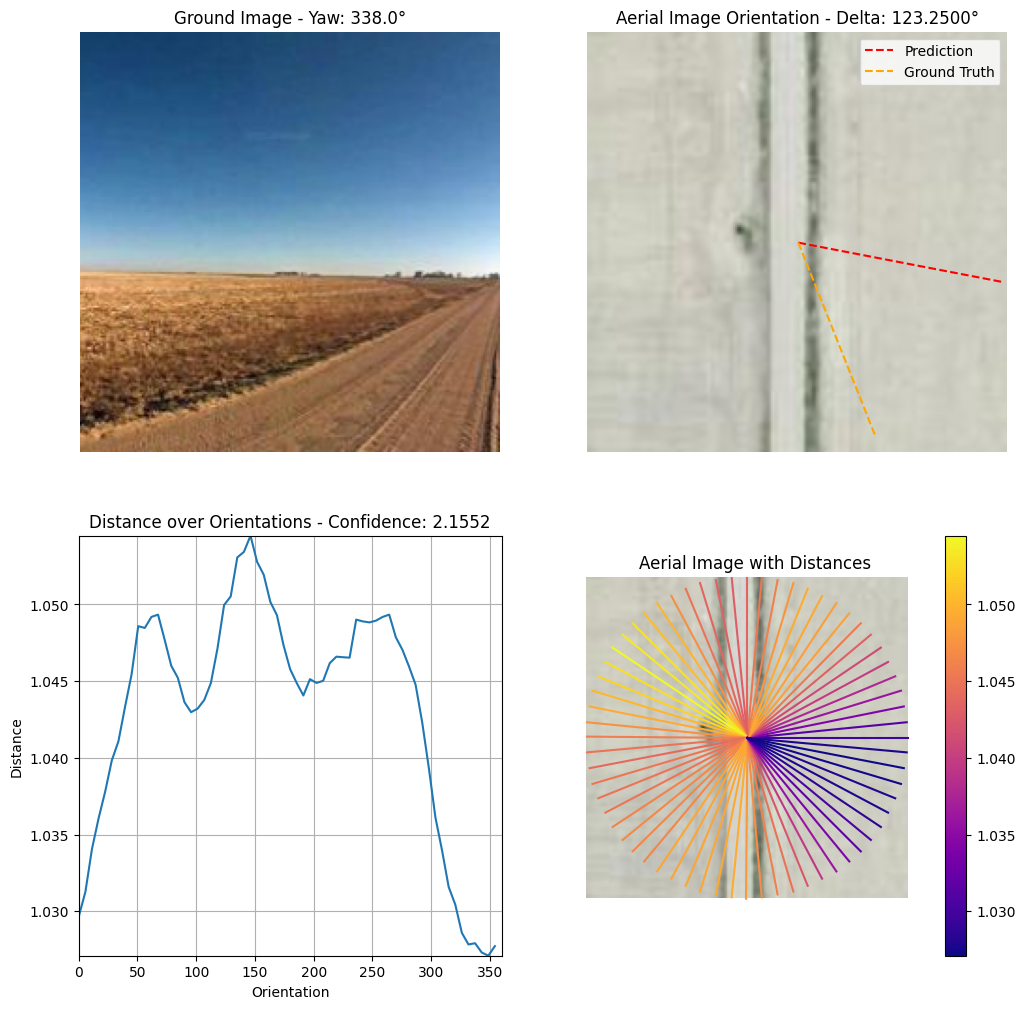

In [ ]:
from sklearn.preprocessing import normalize
import numpy as np
import matplotlib.pyplot as plt

# Normalize the features
normalized_features1 = normalize(tokens_1, axis=1)
normalized_features2 = normalize(tokens_2, axis=1)
print("normalized_features1.shape:", normalized_features1.shape)
print("normalized_features2.shape:", normalized_features2.shape)

grid_size = int(np.sqrt(normalized_features1.shape[0]))  # assuming square grid
print("grid_size:", grid_size)

# Create results directory if it doesn't exist
results_dir = 'results'
if not os.path.exists(results_dir):
    os.makedirs(results_dir)

image_span = 90                     # horizontal fov in degrees
angle_step = image_span / grid_size

# Function to get tokens along a direction (vertical or radial)
def get_direction_tokens(tokens, angle=None, vertical_idx=None, grid_size=16):
    if angle is not None:  # Radial direction
        center = (grid_size // 2, grid_size // 2)
        direction_tokens = []
        indices = []
        for r in range(grid_size):
            delta = 0
            x = int(center[0] + (r+delta) * np.cos(np.deg2rad(angle)))
            y = int(center[1] - (r+delta) * np.sin(np.deg2rad(angle)))
            if 0 <= x < grid_size and 0 <= y < grid_size:
                idx = y * grid_size + x
                if idx < tokens.shape[0]:  # Ensure index is within bounds
                    direction_tokens.append(tokens[idx])
                    indices.append((y, x))
                else:
                    break  # Stop if out of bounds
            else:
                break  # Stop if out of bounds
        return np.array(direction_tokens), indices
    elif vertical_idx is not None:  # Vertical line
        direction_tokens = tokens[vertical_idx::grid_size]  # extract each vertical line
        return direction_tokens, [(i, vertical_idx) for i in range(grid_size)]

# Compute Averaged Tokens using the weight vector, excluding sky tokens
averaged_vertical_tokens = []
for i in range(grid_size):
    vertical_tokens, indices = get_direction_tokens(normalized_features1, vertical_idx=i, grid_size=grid_size)
    valid_tokens = []
    valid_weights = []
    for token, (y, x) in zip(vertical_tokens, indices):
        if grid_mask[y, x] == 1:  # 1 indicates ground, 0 indicates sky
            valid_tokens.append(token)
            valid_weights.append(1.0)  # You can adjust the weights if needed
    
    if valid_tokens:
        valid_tokens = np.array(valid_tokens)
        valid_weights = np.array(valid_weights)
        valid_weights /= np.sum(valid_weights)  # Normalize the weights
        
        # Calculate weighted average only on valid (non-sky) tokens
        weighted_avg = np.average(valid_tokens, axis=0, weights=valid_weights)
        averaged_vertical_tokens.append(weighted_avg)
    else:
        # If no valid tokens are found (i.e., entire column is sky), append a zero vector or any placeholder
        averaged_vertical_tokens.append(np.zeros_like(vertical_tokens[0]))
averaged_vertical_tokens = np.array(averaged_vertical_tokens)


averaged_radial_tokens = []
for beta in np.arange(0, 360, angle_step):
    radial_tokens, _ = get_direction_tokens(normalized_features2, angle=beta, grid_size=grid_size)
    # increasing_weights = np.linspace(0.1, 1, len(radial_tokens))
    increasing_weights = np.linspace(1, 1, len(radial_tokens))
    increasing_weights /= np.sum(increasing_weights)
    weighted_avg = np.average(radial_tokens, axis=0, weights=increasing_weights)
    averaged_radial_tokens.append(weighted_avg)
averaged_radial_tokens = np.array(averaged_radial_tokens)

print("averaged_vertical_tokens.shape:", averaged_vertical_tokens.shape)
print("averaged_radial_tokens.shape:", averaged_radial_tokens.shape)

# Function to calculate global minimum cosine distance
def find_alignment(averaged_vertical_tokens, averaged_radial_tokens, grid_size, image_span):
    
    angle_step = image_span / grid_size
    min_distance = float('inf')
    distances = []

    for j, beta in enumerate(np.arange(0, 360, angle_step)):
        cone_distance = 0
        for i in range(grid_size+1):

            vertical_token = averaged_vertical_tokens[(grid_size-1)-i]
            radial_token = averaged_radial_tokens[int(j + i - grid_size/2) % averaged_radial_tokens.shape[0]]
            # print(f"beta: {beta:.2f} \tangle: {(j + i - grid_size/2)*angle_step} \tindex: {int(j + i - grid_size/2) % averaged_radial_tokens.shape[0]}")       

            cone_distance += (1 - np.dot(vertical_token, radial_token))  # Cosine distance
            # cone_distance += np.linalg.norm(vertical_token - radial_token)  # Euclidean distance

        cone_distance /= grid_size
        if cone_distance < min_distance:
            min_distance = cone_distance
            best_orientation = beta
            print(f"Min Distance: {min_distance:.4f} \tBest Orientation: {best_orientation}°")
        distances.append(cone_distance)

    # Compute confidence
    mean_distance = np.mean(distances)
    std_distance = np.std(distances)
    confidence = (mean_distance - min_distance) / std_distance  # Z-score

    return best_orientation, distances, min_distance, confidence


# Find the best alignment
best_orientation, distances, min_distance, confidence = find_alignment(averaged_vertical_tokens, averaged_radial_tokens, grid_size, image_span)

print(f"Confidence: {confidence:.4f}")

fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(12, 12))

ax1.imshow(ground_image_np)
ax1.set_title("Ground Image - Yaw: {:.1f}°".format(yaw[0]))
ax1.axis('off')

ax2.imshow(aerial_image_np)
radius = aerial_image_np.shape[0] // 2
center = (aerial_image_np.shape[1] // 2, aerial_image_np.shape[0] // 2)
end_x = int(center[0] + radius * np.cos(np.deg2rad(best_orientation)))
end_y = int(center[1] - radius * np.sin(np.deg2rad(best_orientation)))
end_x_GT = int(center[0] + radius * np.cos(np.deg2rad(90 - (yaw - 180))))
end_y_GT = int(center[1] - radius * np.sin(np.deg2rad(90 - (yaw - 180))))
line_pred = ax2.plot([center[0], end_x], [center[1], end_y], color='red', linestyle='--', label='Prediction')
line_gt = ax2.plot([center[0], end_x_GT], [center[1], end_y_GT], color='orange', linestyle='--', label='Ground Truth')
delta_yaw = ((90 - (yaw[0] - 180)) - best_orientation) % 180
if delta_yaw < 0:
    delta_yaw += 180
ax2.set_title("Aerial Image Orientation - Delta: {:.4f}°".format(delta_yaw))
ax2.legend(loc='upper right')
ax2.axis('off')

ax3.plot(np.arange(0, 360, angle_step), distances)
ax3.set_title("Distance over Orientations - Confidence: {:.4f}".format(confidence))
ax3.grid(True)
ax3.set_xlabel('Orientation')
ax3.set_ylabel('Distance')
ax3.set_xlim(0, 360)
ax3.set_ylim(min(distances), max(distances))

ax4.imshow(aerial_image_np)
radius = aerial_image_np.shape[0] // 2
center = (aerial_image_np.shape[1] // 2, aerial_image_np.shape[0] // 2)
min_dist = min(distances)
max_dist = max(distances)
for j, beta in enumerate(np.arange(0, 360, angle_step)):
    end_x = int(center[0] + radius * np.cos(np.deg2rad(beta)))
    end_y = int(center[1] - radius * np.sin(np.deg2rad(beta)))
    color = plt.cm.plasma((distances[j] - min_dist) / (max_dist - min_dist))  # Normalize distances for color map
    ax4.plot([center[0], end_x], [center[1], end_y], color=color)
ax4.set_title("Aerial Image with Distances")
ax4.axis('off')

norm = plt.Normalize(min_dist, max_dist)
sm = plt.cm.ScalarMappable(cmap='plasma', norm=norm)
sm.set_array([])
cbar = plt.colorbar(sm, ax=ax4)

# Determine the next available file number
file_count = len([name for name in os.listdir(results_dir) if name.startswith("summary") and name.endswith(".png")])
file_path = os.path.join(results_dir, f"summary_{file_count}.png")

# Save the figure
plt.savefig(file_path, dpi=300, bbox_inches='tight')

plt.show()

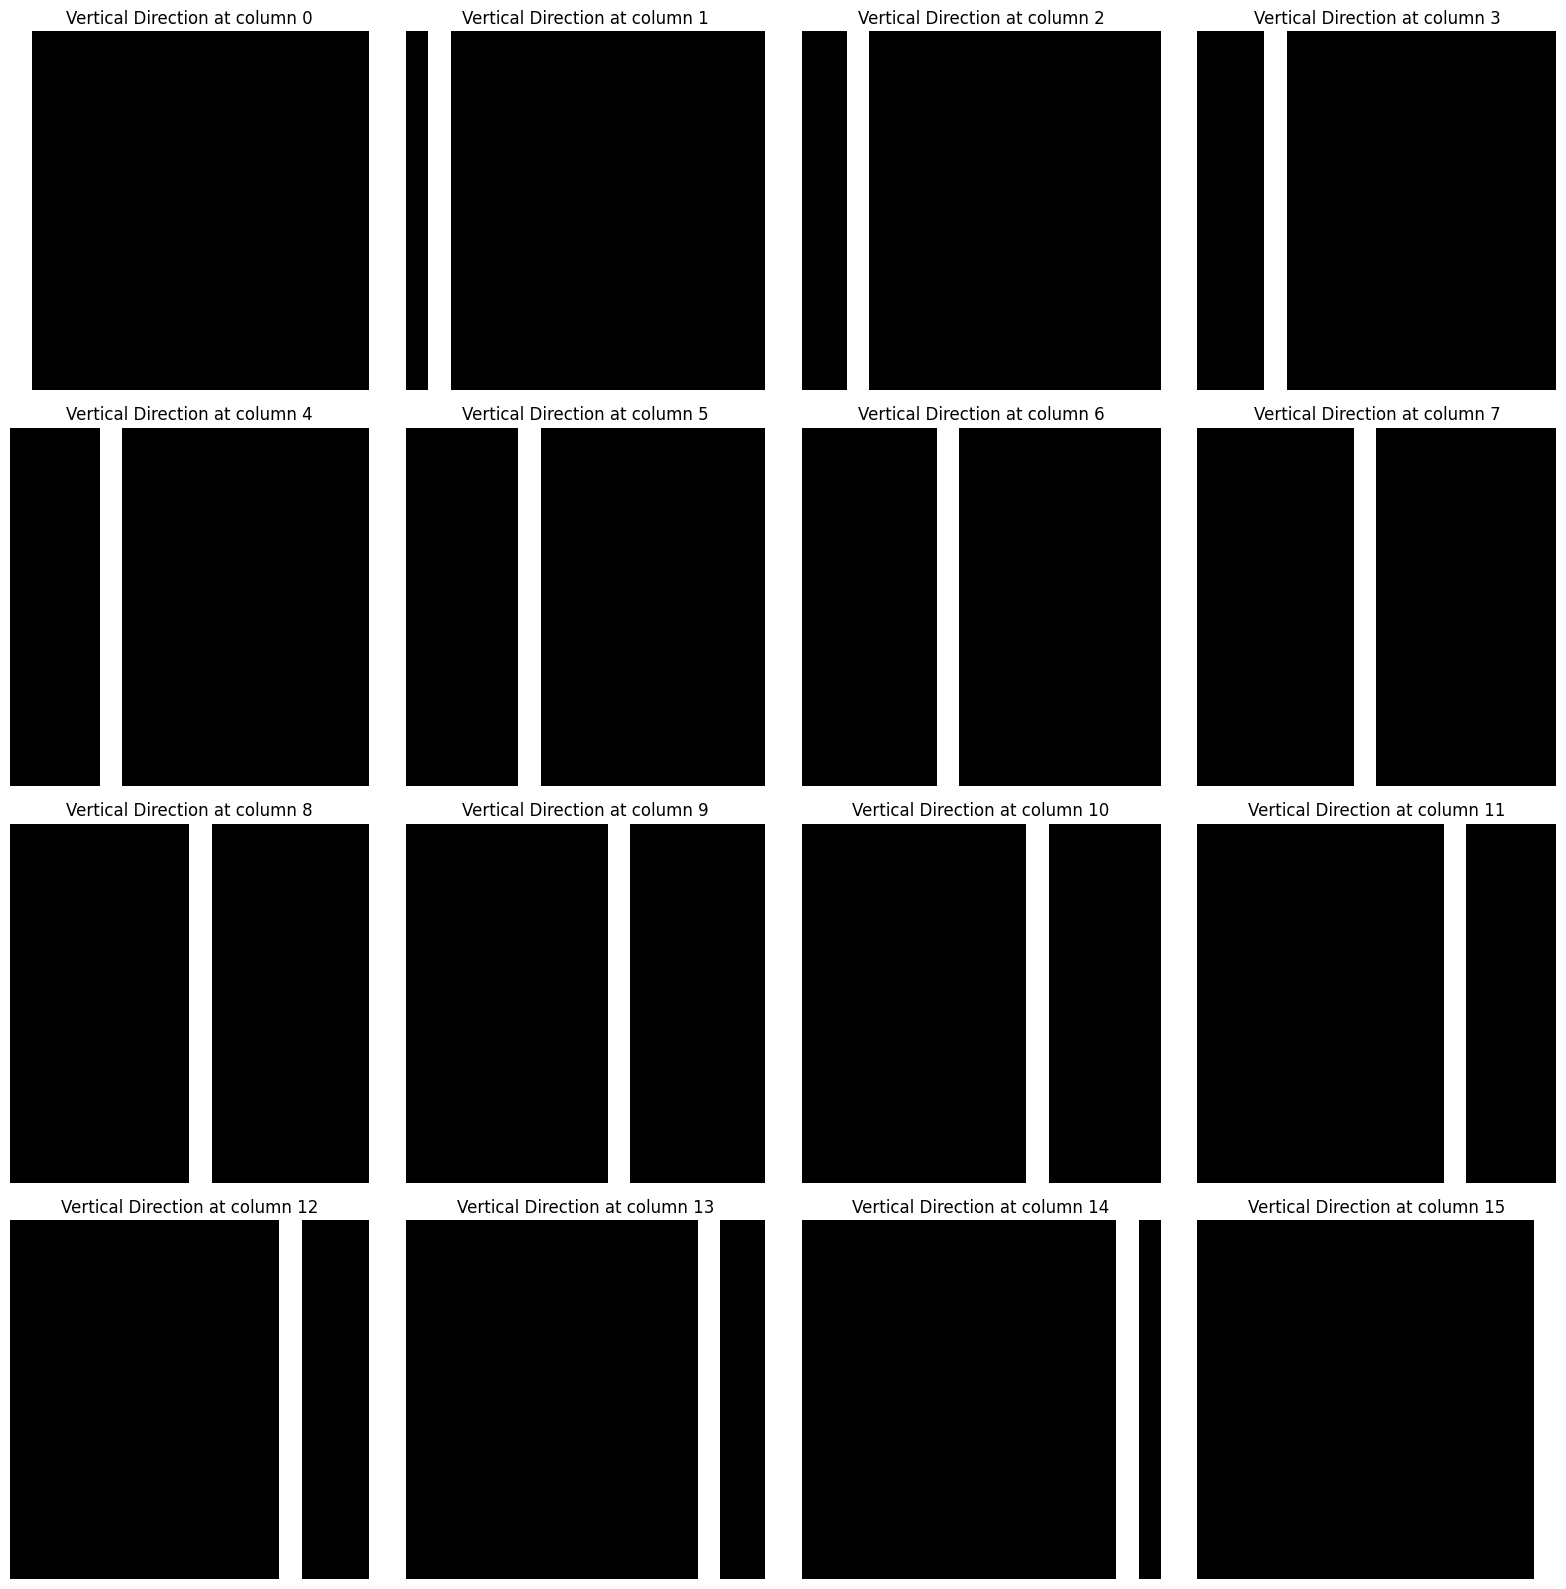

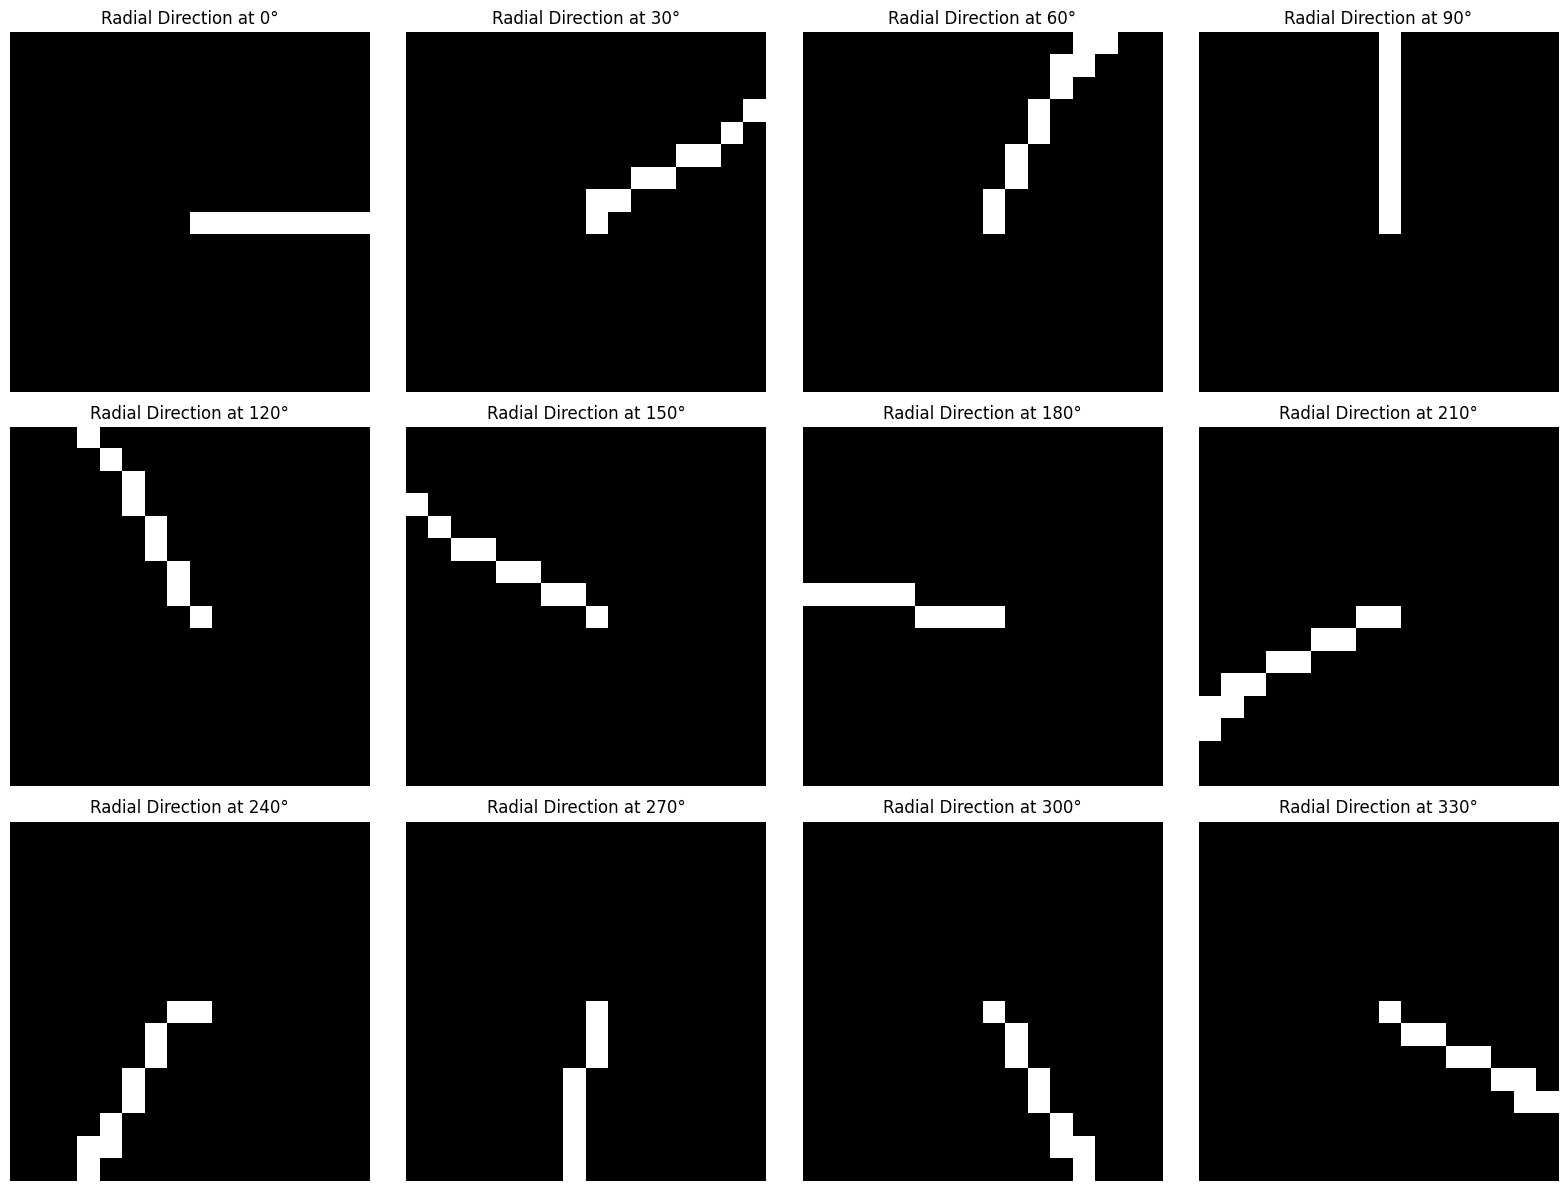

In [ ]:
# Visualization of vertical direction tokens
fig, axes = plt.subplots(4, 4, figsize=(16, 16))
axes = axes.flatten()

for i in range(grid_size):
    grid = np.zeros((grid_size, grid_size))
    for y in range(grid_size):
        grid[y, i] = 1  # Highlight the tokens in the vertical direction

    ax = axes[i]
    ax.imshow(grid, cmap='gray')
    ax.set_title(f"Vertical Direction at column {i}")
    ax.axis('off')

plt.tight_layout()
plt.show()


# Visualization of radial direction tokens
angles = [0, 30, 60, 90, 120, 150, 180, 210, 240, 270, 300, 330]
fig, axes = plt.subplots(3, 4, figsize=(16, 12))
axes = axes.flatten()

for i, angle in enumerate(angles):
    _, indices = get_direction_tokens(normalized_features2, angle=angle, grid_size=grid_size)
    grid = np.zeros((grid_size, grid_size))
    for (y, x) in indices:
        grid[y, x] = 1  # Highlight the tokens in the radial direction

    ax = axes[i]
    ax.imshow(grid, cmap='gray')
    ax.set_title(f"Radial Direction at {angle}°")
    ax.axis('off')

plt.tight_layout()
plt.show()

normalized_features1.shape: (256, 768)
normalized_features2.shape: (256, 768)
Selected index from aerial features:  248


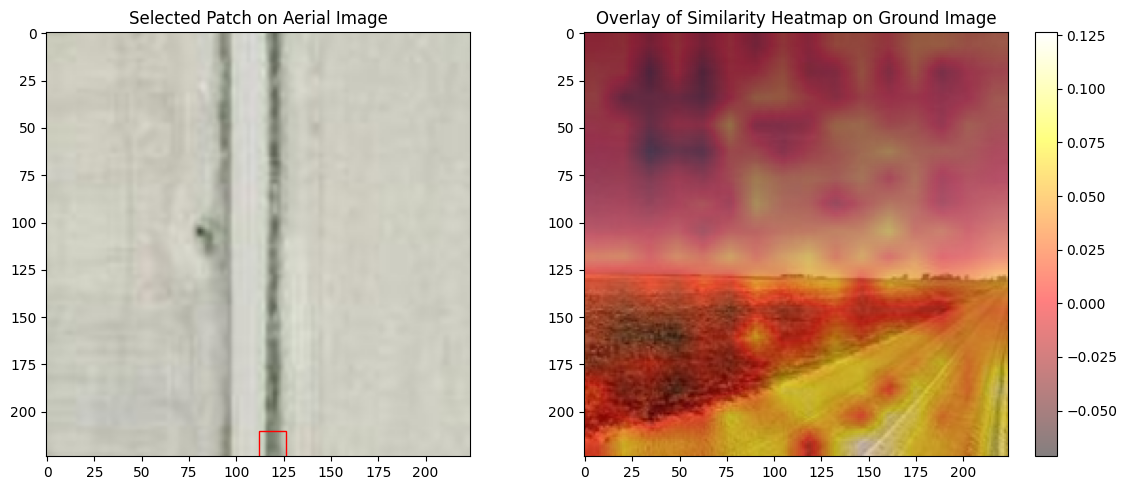

In [ ]:
from sklearn.preprocessing import normalize

# Normalize the features
normalized_features1 = normalize(tokens_1, axis=1)
normalized_features2 = normalize(tokens_2, axis=1)
print("normalized_features1.shape:", normalized_features1.shape)
print("normalized_features2.shape:", normalized_features2.shape)

# Take one element from features2 (aerial image features)
random_index = np.random.randint(0, tokens_2.shape[0])
selected_feature = normalized_features2[random_index]
print("Selected index from aerial features: ", random_index)

# Show which small piece of the aerial image was chosen
row_aerial, col_aerial = dm.idx_to_source_position(random_index, grid_size2, resize_scale2)
selected_patch_size = dm.model.patch_size * resize_scale2

# Compute the distance (inner product) between this element and all elements of features1 (ground image features)
distances = np.dot(normalized_features1, selected_feature)

# Reshape into the appropriate dimensions for the ground image
reshaped_distances = distances.reshape(grid_size1)

# Resize the heatmap to fit the ground image
resized_heatmap = cv2.resize(reshaped_distances, (ground_image_vis.shape[1], ground_image_vis.shape[0]))

# Visualization
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))
ax1.imshow(aerial_image_vis)
rect = plt.Rectangle((col_aerial - selected_patch_size / 2, row_aerial - selected_patch_size / 2),
                     selected_patch_size, selected_patch_size,
                     linewidth=1, edgecolor='r', facecolor='none')
ax1.add_patch(rect)
ax1.set_title('Selected Patch on Aerial Image')
alpha = 0.5
ax2.imshow(ground_image_vis)
img2 = ax2.imshow(resized_heatmap, cmap='hot', interpolation='nearest', alpha=alpha)
fig.colorbar(img2, ax=ax2)
ax2.set_title('Overlay of Similarity Heatmap on Ground Image')
fig.tight_layout()